# Notebook for Disinformation classification with BERT

# Load the dataset

In [86]:
!pip install --quiet transformers
!pip install --quiet datasets

In [87]:
import pandas as pd

In [88]:
import csv
df_true = pd.read_csv('/kaggle/input/syn-data/synthetic.csv', usecols=['article_short'], index_col=False)
df_fake = pd.read_csv('/kaggle/input/syn-data/fake_news.txt', index_col=False, on_bad_lines="skip", quoting=csv.QUOTE_NONE, header=None)

In [89]:
df_fake.columns = ['fake_news']

In [90]:
df_fake['label'] = 0
df_true['label'] = 1
df_fake.head()

,fake_news,label
0,"""BREAKING: Tanjong Rhu Residents to Receive FR...",0
1,You Won't Believe the SHOCKING Truth About Tan...,0
2,UNBELIEVABLE OFFER: Get Your Dream Home in Tan...,0
3,Tanjong Rhu Residents to Receive MASSIVE Subsi...,0
4,Don't Miss Out: Tanjong Rhu's February BTO Lau...,0


In [91]:
df_fake['fake_news'].describe()

count     29131
unique    27750
top           "
freq        351
Name: fake_news, dtype: object

In [92]:
df_fake.drop_duplicates(inplace=True)

In [93]:
def remove_invalid(text):
    if len(text) < 10:
        return 1
    else:
        return 0

df_fake['to_remove'] = df_fake['fake_news'].apply(remove_invalid)
df_fake = df_fake.loc[df_fake['to_remove'] == 0, :]
df_fake.drop(axis=1, columns=['to_remove'], inplace=True)
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27429 entries, 0 to 29130
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fake_news  27429 non-null  object
 1   label      27429 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 642.9+ KB


In [94]:
df_fake = df_fake.rename(columns={'fake_news': 'text'})
df_true = df_true.rename(columns={'article_short': 'text'})
df = pd.concat([df_fake, df_true], ignore_index=True)

In [95]:
len(df)

34245

In [96]:
import re

def fix_contractions(text: str) -> str:
    """
    Replaces common spaced-out contractions like:
      - didn t -> didn't
      - he s   -> he's
      - I ll   -> I'll
    This is a simplified approach using regex.
    """
    # Fix "n t" → "n't" (e.g. "couldn t" -> "couldn't")
    text = re.sub(r"(\b)([A-Za-z]+)n\s+t(\b)", r"\2n't", text)
    
    # Fix "' s" → "'s" (e.g. "he s" -> "he's")
    text = re.sub(r"(\b)([A-Za-z]+)\s+s(\b)", r"\2's", text)

    # Fix "' d" → "'d" (e.g. "you d" -> "you'd")
    text = re.sub(r"(\b)([A-Za-z]+)\s+d(\b)", r"\2'd", text)

    # Fix "' ll" → "'ll" (e.g. "I ll" -> "I'll")
    text = re.sub(r"(\b)([A-Za-z]+)\s+ll(\b)", r"\2'll", text)
    
    # Fix "' re" → "'re" (e.g. "you re" -> "you're")
    text = re.sub(r"(\b)([A-Za-z]+)\s+re(\b)", r"\2're", text)

    # Fix "' ve" → "'ve" (e.g. "they ve" -> "they've")
    text = re.sub(r"(\b)([A-Za-z]+)\s+ve(\b)", r"\2've", text)

    return text

def insert_paragraph_breaks(text: str) -> str:
    """
    Insert paragraph breaks before common patterns like a new tweet handle 
    or certain punctuation that might indicate a new 'section'.
    Adjust the pattern to your preferences.
    """
    # Example: break before "Donald J. Trump (@...)" or "Bishop Talbert..."
    # Or break after certain punctuation like "!). "
    
    # Put a newline before a Twitter handle in parentheses, e.g. (@something)
    text = re.sub(r"(\([@].*?\))", r"\n\1", text)
    
    # Insert a newline after a period if there's another capital letter soon after.
    # This is naive but can help readability.
    text = re.sub(r"\.\s+([A-Z])", r".\n\1", text)
    
    return text

def clean_up_spacing(text: str) -> str:
    """
    Removes extra whitespace, leading/trailing spaces, etc.
    """
    # Replace multiple spaces/newlines with a single space
    text = re.sub(r"\s+", " ", text)
    
    # Optionally, convert triple dot "..." to something consistent
    text = re.sub(r"\.\s*\.\s*\.", "...", text)

    # Trim leading and trailing space
    text = text.strip()
    
    return text

def format_text(raw: str) -> str:
    """
    Main function to fix contractions, insert paragraph breaks, and clean spacing.
    """
    stage1 = fix_contractions(raw)
    stage2 = insert_paragraph_breaks(stage1)
    final_text = clean_up_spacing(stage2)
    return final_text


In [97]:
def remove_last_chars(text):
    return text[:-50]

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34245 entries, 0 to 34244
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    34245 non-null  object
 1   label   34245 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 535.2+ KB


# Drop NA

In [99]:
df.dropna(axis=0, inplace=True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34245 entries, 0 to 34244
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    34245 non-null  object
 1   label   34245 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 535.2+ KB


In [101]:
import datasets

In [102]:
df = df.reset_index(drop=True)

In [103]:
dataset = datasets.Dataset.from_pandas(df)
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 34245
})

## Split training set into train-val (80/20)

In [104]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(list(dataset), test_size=0.3, random_state=42)

In [105]:
len(train), len(validation)

(23971, 10274)

# Using and exploring the Tokenizer from `transformers`

In [106]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [107]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Finding max length

Maximum number of tokens in any text sample: 120
count    34245.000000
mean        23.677792
std         13.578043
min          2.000000
25%         17.000000
50%         20.000000
75%         25.000000
max        120.000000
Name: token_length, dtype: float64


<Axes: >

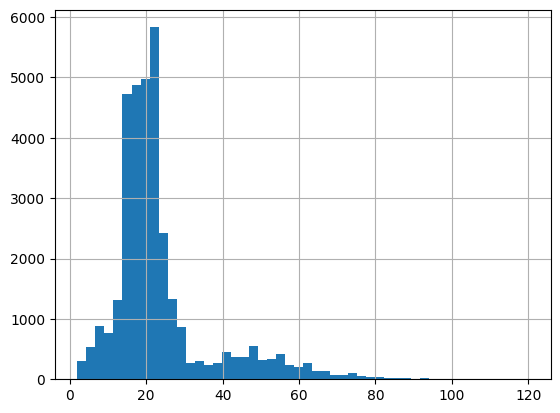

In [108]:
# Suppose your dataframe has a column "text"
def count_tokens(text):
    # Tokenize the text and return the length
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Apply the function to each row in the 'text' column
df['token_length'] = df['text'].apply(count_tokens)

# Now you can inspect the distribution of token lengths
max_length = df['token_length'].max()
print("Maximum number of tokens in any text sample:", max_length)

# You might also look at basic statistics
print(df['token_length'].describe())  # to see mean, std, percentile, etc.

# Optionally, plot a histogram to visualize the distribution
df['token_length'].hist(bins=50)


In [109]:
MAX_LEN = 64

# Create Custom Dataset Class

In [110]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):

    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.features = [d['text'] for d in self.data]
        self.labels = [d['label'] for d in self.data]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = str(self.features[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            feature,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': feature,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.float)
        }

In [111]:
import numpy as np

train_dataset = CustomDataset(train, tokenizer, MAX_LEN)
val_dataset = CustomDataset(validation, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [112]:
iter_sample = iter(train_loader)
sample = next(iter_sample)
sample.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

# Building the Model

In [113]:
from torch import nn
from transformers import BertModel

class CustomModel(nn.Module):

    def __init__(self, numcl=1):
        super().__init__()
        self.model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float, attn_implementation="sdpa", return_dict=False)
        self.drop = nn.Dropout(p=0.4)
        self.fc = nn.Linear(self.model.config.hidden_size, numcl)

    def forward(self, input_ids, attn_mask):
        _, pooled_output = self.model(
            input_ids=input_ids,
            attention_mask=attn_mask)
        output = self.drop(pooled_output)
        return self.fc(output)


# Hyperparameters

In [114]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS = 10

model = CustomModel()
model = nn.DataParallel(model)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Creating the Main Functions

### Training function

In [115]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    model.train()

    losses = []

    for batch_idx, data in enumerate(train_loader):
        inputs, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

        optimizer.zero_grad()
        preds = model(inputs, attention_mask)
        labels = labels.unsqueeze(1)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return losses

### Validation function

In [116]:
def evaluate(data_loader, model, criterion, device):
    model.eval()

    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_loss = 0

        for data in data_loader:
            features, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

            outputs = model(features, attention_mask)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # output is raw logits
            outputs_sigmoid = torch.sigmoid(outputs)
            preds = (outputs_sigmoid >= 0.5).float()
            
            total_correct += (preds.squeeze() == labels.squeeze()).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = total_correct / total_samples * 100
    return avg_loss, accuracy


In [117]:
def train_modelcv(train_loader, test_loader, model, criterion, optimizer, num_epochs, device, scheduler=None):
    train_losses = []
    val_losses = []
    best_measure = 0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        val_loss, measure = evaluate(test_loader, model, criterion, device)
        val_losses.append(val_loss)

        # scheduler.step(measure)

        print("Performance measure: ", measure)
        print("Current Learning Rate: ", optimizer.param_groups[0]['lr'])

        if measure > best_measure:
            best_weights = model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print(f"Current Best is epoch {best_epoch} with {best_measure} %")

    return best_weights, best_measure, best_epoch, train_losses, val_losses

In [118]:
best_weights, best_measure, best_epoch, train_losses, val_losses = train_modelcv(train_loader,
                                                                                 val_loader,
                                                                                 model,
                                                                                 criterion,
                                                                                 optimizer,
                                                                                 NUM_EPOCHS,
                                                                                 device)

Epoch 0/9
----------
Performance measure:  99.12400233599377
Current Learning Rate:  2e-05
Current Best is epoch 0 with 99.12400233599377 %
Epoch 1/9
----------
Performance measure:  99.45493478684057
Current Learning Rate:  2e-05
Current Best is epoch 1 with 99.45493478684057 %
Epoch 2/9
----------
Performance measure:  99.48413470897411
Current Learning Rate:  2e-05
Current Best is epoch 2 with 99.48413470897411 %
Epoch 3/9
----------
Performance measure:  99.36733502043995
Current Learning Rate:  2e-05
Epoch 4/9
----------
Performance measure:  99.47440140159625
Current Learning Rate:  2e-05
Epoch 5/9
----------
Performance measure:  99.16293556550517
Current Learning Rate:  2e-05
Epoch 6/9
----------
Performance measure:  99.43546817208487
Current Learning Rate:  2e-05
Epoch 7/9
----------
Performance measure:  99.45493478684057
Current Learning Rate:  2e-05
Epoch 8/9
----------
Performance measure:  99.43546817208487
Current Learning Rate:  2e-05
Epoch 9/9
----------
Performance m

In [119]:
torch.save(best_weights, "best_bert_weights.pt")

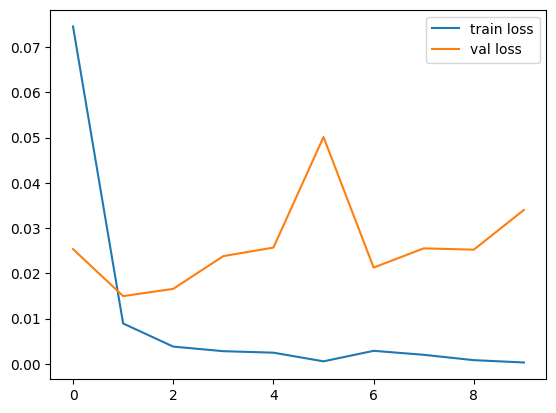

In [120]:
import matplotlib.pyplot as plt

train_losses = [np.mean(i) for i in train_losses]

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# Run on test set

In [121]:
df_true = pd.read_csv('/kaggle/input/testing-data/test_data.csv', usecols=['article_text'])
df_fake = pd.read_csv('/kaggle/input/testing-data/test_data.csv', usecols=['fake_news'])

In [122]:
df_fake['label'] = 0
df_true['label'] = 1
df_fake.head()

,fake_news,label
0,Singapore experienced its coolest winter on re...,0
1,"K-pop sensation, Jimin, is set to embark on a ...",0
2,KFC in Malaysia is launching a limited-edition...,0
3,Vice President Kamala Harris has postponed her...,0
4,"A new initiative, ""Conversations Beyond,"" has ...",0


In [123]:
df_fake = df_fake.rename(columns={'fake_news': 'text'})
df_real = df_true.rename(columns={'article_text': 'text'})
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,text,label
0,A former human resources sales agent who cheat...,1
1,"On Dec 22, Singapore Post (SingPost) plunged i...",1
2,Malaysia's emerging snail farming industry is ...,0
3,"In April this year, renowned entertainer Suhai...",1
4,A 22-year-old man who sexually exploited two b...,1


In [124]:
dataset_test = datasets.Dataset.from_pandas(df)
dataset_test

Dataset({
    features: ['text', 'label'],
    num_rows: 398
})

In [125]:
test_dataset = CustomDataset(dataset_test, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
model.load_state_dict(torch.load("best_bert_weights.pt"))

model.eval()
correct_prediction = {}
wrong_prediction = {}
true_labels = []
pred_labels = []


with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0
    for idx, data in enumerate(test_loader):
        if idx % 20 == 0:
            print(f"Processing Batch {idx}")
        features, attention_mask, labels = data['input_ids'].to(device), data['attention_mask'].to(device), data['targets'].to(device)

        logits = model(features, attention_mask)
        labels = labels.unsqueeze(1)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        outputs = torch.sigmoid(logits)
        preds = (outputs >= 0.5).float()

        # run this only when dictionaries are empty
        if not correct_prediction and not wrong_prediction:
            for i in range(features.size(0)):
                original_text = data['review_text'][i]
                token_ids = list(map(lambda x: x.item(), data['input_ids'][i]))
                tokens = tokenizer.convert_ids_to_tokens(token_ids)
                raw_logits = logits[i].tolist()
    
                entry = {
                    "original_text": original_text,
                    "tokens_and_id": (tokens, token_ids),
                    "raw_logits": raw_logits,
                    "sigmoid_prob": outputs[i],
                    "true_label": labels[i],
                    "pred_label": preds[i]
                }
    
                if preds[i] == labels[i]:
                    if not correct_prediction:  # Add only one entry.
                        correct_prediction = entry
                else:
                    if not wrong_prediction:  # Add only one entry.
                        wrong_prediction = entry
        total_correct += (preds.squeeze() == labels.squeeze()).sum().item()
        total_samples += labels.size(0)
        pred_labels.extend(preds.squeeze())
        true_labels.extend(labels.squeeze())

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples * 100
        

In [ ]:
print(f"Avg loss: {avg_loss}")
print(f"Test accuracy: {accuracy}")

# Give your own sample text here

In [128]:
# replace with whatever text you wanna test out
sample_text_false = "Register claim RM8.88! Join your first promotion to receive up to RM1440 and enjoy unlimited cashback. Register at: https://mysjili.com/RF8AA6383 "
sample_text_true = "Dear CPF Member,Your latest CPF Yearly Statement of Account is ready. To view your statement, please visit cpf.gov.sg/YearlyStatementFAQ for details."

# Testing on Fake news sample

In [129]:
encoding = tokenizer.encode_plus(
            sample_text_false,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [130]:
feature = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [131]:
outputs = model(feature, attention_mask)

# output is raw logits
outputs_sigmoid = torch.sigmoid(outputs)
preds = (outputs_sigmoid >= 0.7).float()

In [132]:
prediction = 'likely true' if preds == 1 else 'likely false'

In [133]:
print(f"The sample text is {prediction} news, confidence {outputs_sigmoid}")

The sample text is likely false news, confidence tensor([[2.1958e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)


 # testing on true sample news

In [134]:
encoding = tokenizer.encode_plus(
            sample_text_true,
            add_special_tokens=True,
            max_length=256,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [135]:
feature = encoding['input_ids']
attention_mask = encoding['attention_mask']
outputs = model(feature, attention_mask)

# output is raw logits
outputs_sigmoid = torch.sigmoid(outputs)
preds = (outputs_sigmoid >= 0.7).float()

In [136]:
prediction = 'likely true' if preds == 1 else 'likely false'
print(f"The sample text is {prediction} news, confidence: {outputs_sigmoid}")

The sample text is likely true news, confidence: tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
